In [1]:
from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from data import ImageDataset
from features import VggFeaturize
from preprocess import VggPreprocess

In [2]:
train_dir = './dataset/'

# load and preprocess image data
preprocess = VggPreprocess()
train_data = ImageDataset(root_dir=train_dir, image_size=(224, 224),
                          preprocess=preprocess)

# load pre-trained VGG16 model; remove top fc and softmax layers
# note when running for very first time, it might take some time
# before vgg16 model is downloaded
model = VGG16(weights='imagenet', include_top=False)

# extract features from image data
# this just means passing image data through the model above
# and storing the output of the last pooling layer
# the pooling layer acts as an image embedding
featurize = VggFeaturize(model=model)
X = []
for sample in train_data:
    X.append(featurize(sample))

X = np.array(X)
X.shape

(998, 25088)

In [3]:
# run PCA on extracted features and project to just two principal
# components
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X.shape

(998, 2)

In [4]:
# % of variance explained for each of the two pca components
# it's very small - 7-8% but we hope these two components
# account for most of the important features needed to 
# differentiate image clusters
pca.explained_variance_ratio_

array([0.04332358, 0.0314835 ], dtype=float32)

In [5]:
# perform k-means clustering
# compute sum of squared distances for range of values of k
sse = []
ks = list(range(2, 10))
for k in ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

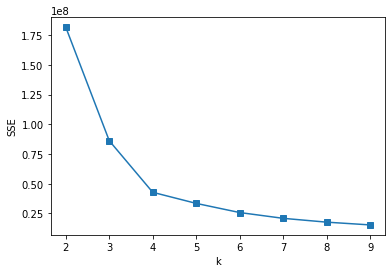

In [6]:
# plot SSE against number of clusters k;
# note the "elbow" or "knee", which indicates optimal number of clusters
# in our case that number is 4 - "cars", "bikes", "dogs" and "fish/fishing"
plt.plot(ks, sse, 's-')
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

In [7]:
# perform k-means clustering using the optimal k based on the "elbow" above
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=0)

In [8]:
# store our cluster/label predictions
y = kmeans.labels_
y.shape

(998,)

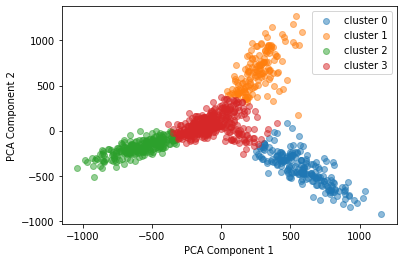

In [9]:
# plot clusters in 2d space
# in general we see very nice separation of clusters
# some overlap is seen partly due to overlapping high-level
# features (e.g. people can be seen in pictures with bikes, 
# cars and fishing), but also due to low-level features like
# colours and shapes
for k in range(n_clusters):
    plt.scatter(X[y == k, 0], X[y == k, 1], label='cluster {}'.format(k),
                alpha=.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

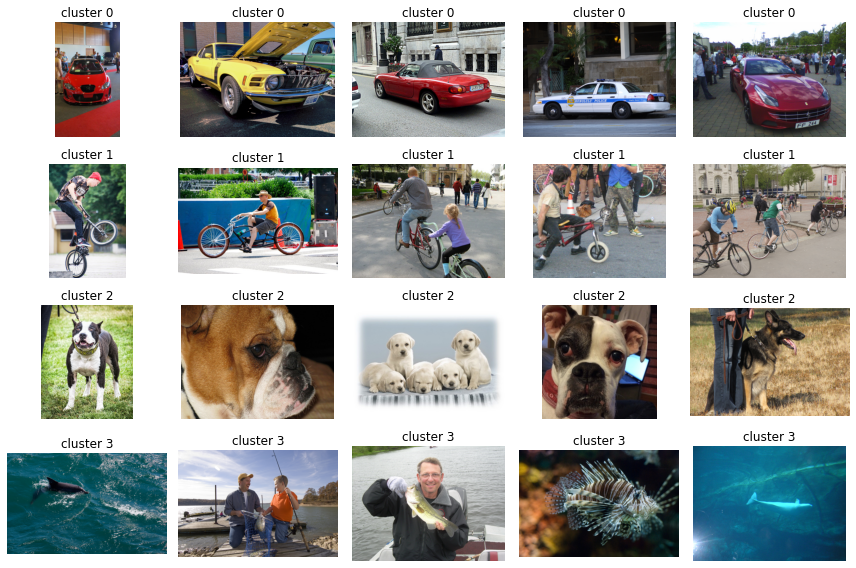

In [11]:
# plot five images from each cluster

fig, axs = plt.subplots(n_clusters, 5, figsize=(12, 8))
for k in range(n_clusters):
    indexes = np.where(y == k)[0][:5]
    for i, index in enumerate(indexes):
        train_data.show_image(index, title='cluster {}'.format(k),
                                ax=axs[k, i])
plt.tight_layout()

In [12]:
# load, preprocess and featurize test set 
# we will run inference on test set to find
# which cluster it belongs to, and hence which
# images from train set are most similar
test_dir = './bonus_exercise_dataset/'

test_data = ImageDataset(root_dir=test_dir, image_size=(224, 224),
                         preprocess=preprocess)
X_test = []
for sample in test_data:
    X_test.append(featurize(sample))

X_test = pca.transform(np.array(X_test))
X_test.shape

(50, 2)

In [13]:
# run inference on test set and view
# predicted clusters
y_test = kmeans.predict(X_test)
y_test

array([0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 3, 0, 2, 0], dtype=int32)

In [14]:
# find the predominant cluster
# it will be the "car" cluster
y_test_cluster = np.bincount(y_test).argmax()
y_test_cluster

0

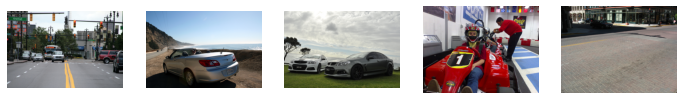

In [16]:
# check some of the mis-predicted clusters
# in general there seems to be a problem 
# when there are poor lightning conditions
# or cars are not very visible or are obstructed
# in some way
incorrect = list(np.where(y_test != y_test_cluster)[0])

fig, axs = plt.subplots(1, 5, figsize=(12, 8))
for i, index in enumerate(incorrect[:5]):
    test_data.show_image(index, ax=axs[i])